In [3]:
# Importing Libraries 
import serial 
import time 
import matplotlib.pyplot as plt

from matplotlib import style
import numpy as np
from Arduino_tools import str2arr, calibrate
from numpy.linalg import norm

#style.available
style.use('classic') # This is the style for the plotting



In [4]:
arduino = serial.Serial(port='COM5', baudrate=9600, timeout=.1) # We are connecting to the arduino in this part

In [5]:
x0 = np.array([0,0,0]) # Defining initial position
v0 = np.array([0,0,0]) # Defining initial velocity
a0 = np.array([0,0,0])

# Initializing list of arrays
x_list = []
v_list = []
a_list = []
a_avg5_list = []

butt_state_list = [] # Store button state

x_list.append(x0)
v_list.append(v0)
a_list.append(a0)
a_avg5_list.append(a0)


dt = 1e-3*10 # miliseconds to second

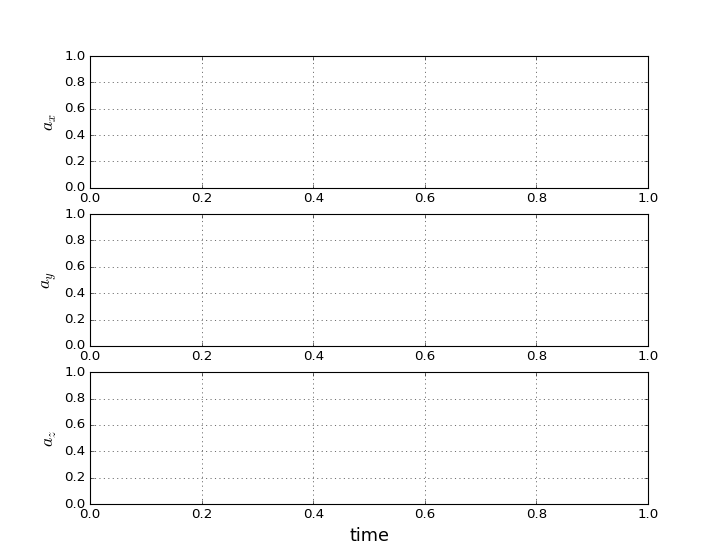

In [6]:
%matplotlib widget

# Now we are going to make a code to plot things
#ax = plt.figure(figsize = (6,6)).add_subplot(projection='3d')
fig, axs = plt.subplots(nrows = 3, ncols = 1,figsize= (9,7)) # Create three rows, 1 axis each

axs[0].set_ylabel("$a_x$", fontsize = 16)
axs[1].set_ylabel("$a_y$", fontsize = 16)
axs[2].set_ylabel("$a_z$", fontsize = 16)
axs[2].set_xlabel("time", fontsize = 16)
axs[0].grid(True)
axs[1].grid(True)
axs[2].grid(True)


plt.ion()
plt.show()


In [7]:
# Calibration part of the code
calibration_info = calibrate(arduino, sample_size= 1000)

accel_offset = calibration_info['offset'] # To store the offset
print(accel_offset)

[-0.36745317  0.36358803  0.14625729]


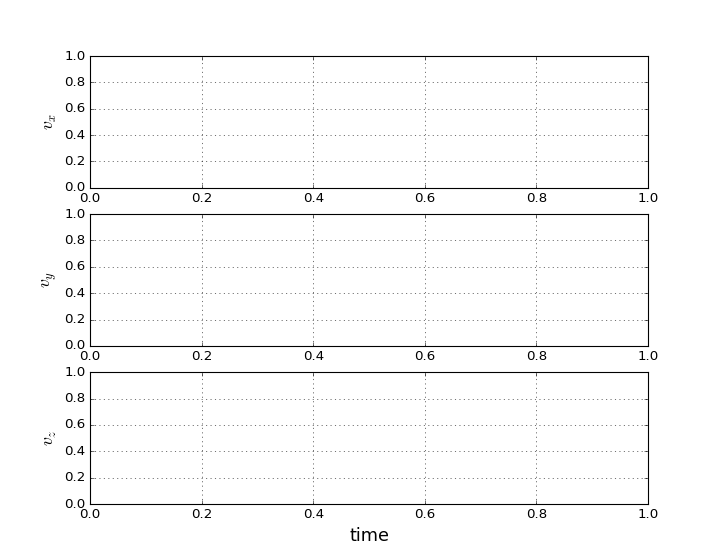

In [8]:
%matplotlib widget
# Now we are going to make a code to plot things
#ax = plt.figure(figsize = (6,6)).add_subplot(projection='3d')
fig2, axs2 = plt.subplots(nrows = 3, ncols = 1,figsize= (9,7)) # Create three rows, 1 axis each



axs2[0].set_ylabel("$v_x$", fontsize = 16)
axs2[1].set_ylabel("$v_y$", fontsize = 16)
axs2[2].set_ylabel("$v_z$", fontsize = 16)
axs2[2].set_xlabel("time", fontsize = 16)
axs2[0].grid(True)
axs2[1].grid(True)
axs2[2].grid(True)


plt.ion()
plt.show()

In [9]:


first_time = True # The first run

step = 0 # Number of steps, this is for plotting. We will only plot one time every 100 steps
tic = time.time() # Get initial time for plotting

while True:
	

	message = str(arduino.readline()) # Read arduino serial communication, turning binary into string type

	
    
	if message != "b''": # If message is not empty, then continue. All of the messages are written in the form -> b'something'

		# Preprocessing the message from string to arrays
		preprocess = message.split("'")[1:-1][0].split(";")[:-1] # string splitting
		states = [str2arr(coor) for coor in preprocess] # Convert string to coordinate using the str2arr defined above.


		for state in states: # For each state, do these things
			if len(state) == 4: # Sometimes there's issue with the serial communication.
				state_now = state
			step += 1 # Keep track of the step
			accel_mg = np.array(state_now[:-1]) # Get only the accelerations, this is still in milli gravity
			accel = 9.81e-3*accel_mg  - accel_offset# Convert from milligravity -> m/s^2
			#print(accel)
			butt_state_list.append(state_now[-1]) # Store button state

			a_list.append(accel) # Store acceleration

				

			# Verlet integration
			x_list.append(x_list[-1] + v_list[-1]*dt + 0.5*a_list[-2]*(dt**2))
			v_list.append(v_list[-1]+0.5*(a_list[-2]+a_list[-1])*dt)


			# Plotting stuff
			if step%100 == 0:
				fig.canvas.flush_events()
				toc = time.time()
				plot_time = toc-tic
				axs[0].scatter(plot_time, a_list[-1][0])
				axs[1].scatter(plot_time, a_list[-1][1])
				axs[2].scatter(plot_time, a_list[-1][2])
				axs[0].set_xlim([0,plot_time])
				axs[1].set_xlim([0,plot_time])
				axs[2].set_xlim([0,plot_time])
				axs2[0].scatter(plot_time, v_list[-1][0])
				axs2[1].scatter(plot_time, v_list[-1][1])
				axs2[2].scatter(plot_time, v_list[-1][2])
				axs2[0].set_xlim([0,plot_time])
				axs2[1].set_xlim([0,plot_time])
				axs2[2].set_xlim([0,plot_time])
				fig.canvas.draw()
				fig2.canvas.draw()


			
			

KeyboardInterrupt: 

In [12]:
np_acceleration = np.array(a_list[1:])

In [27]:
np_acceleration[:,0] = np_acceleration[:,0] + accel_offset[0]
np_acceleration[:,1] = np_acceleration[:,1] + accel_offset[1]
np_acceleration[:,2] = np_acceleration[:,2] + accel_offset[2]

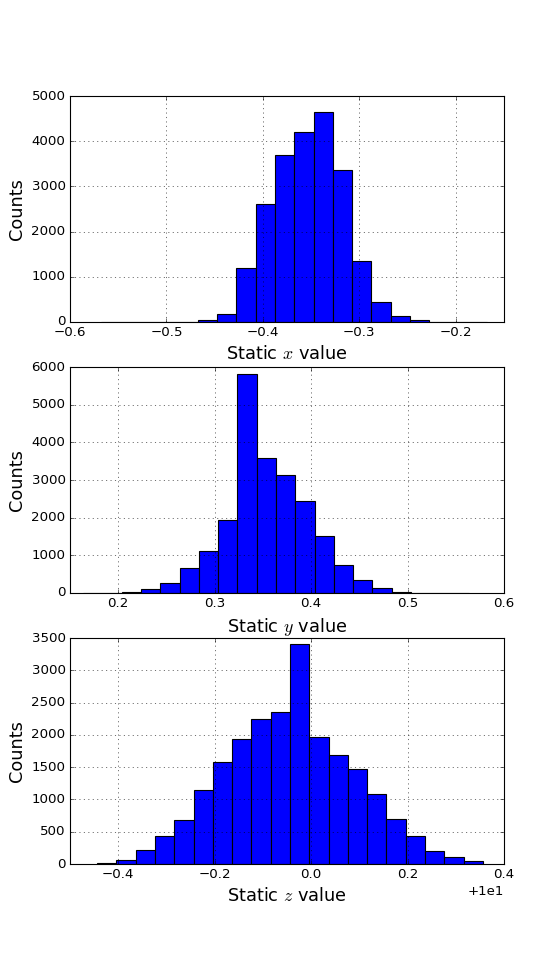

In [49]:
Fig3, axs3 = plt.subplots(nrows=3, ncols=1, figsize = (7,12))

axs3[0].hist(np_acceleration[:,0], bins = 20, range = (accel_offset[0]-0.2, accel_offset[0]+0.2))
axs3[0].set_xlabel('Static $x$ value', fontsize = 16)
axs3[0].set_ylabel('Counts', fontsize = 16)
axs3[0].grid(True)

axs3[1].hist(np_acceleration[:,1], bins = 20, range = (accel_offset[1]-0.2, accel_offset[1]+0.2))
axs3[1].set_xlabel('Static $y$ value', fontsize = 16)
axs3[1].set_ylabel('Counts', fontsize = 16)
axs3[1].grid(True)

axs3[2].hist(np_acceleration[:,2], bins = 20, range = (9.81+accel_offset[2]-0.4, 9.81+accel_offset[2]+0.4))
axs3[2].set_xlabel('Static $z$ value', fontsize = 16)
axs3[2].set_ylabel('Counts', fontsize = 16)
axs3[2].grid(True)


In [47]:
print(a_list)

[array([0, 0, 0]), array([-0.02494683,  0.01900197,  9.79127271]), array([ 0.02410317, -0.07909803,  9.77165271]), array([-0.01513683, -0.07909803,  9.57545271]), array([ 4.48317000e-03, -2.02380300e-02,  9.63431271e+00]), array([ 0.02410317, -0.02023803,  9.69317271]), array([-0.02494683, -0.02023803,  9.99728271]), array([-0.01513683,  0.01900197,  9.69317271]), array([ 4.37231700e-02, -6.18030000e-04,  9.84032271e+00]), array([-0.04456683, -0.02023803, 10.09538271]), array([0.04372317, 0.02881197, 9.73241271]), array([0.02410317, 0.06805197, 9.65393271]), array([-0.02494683, -0.03985803,  9.82070271]), array([-0.02494683,  0.01900197,  9.91880271]), array([0.02410317, 0.01900197, 9.75203271]), array([4.48317000e-03, 2.88119700e-02, 9.87956271e+00]), array([-0.02494683, -0.11833803,  9.77165271]), array([-0.06418683,  0.06805197,  9.71279271]), array([ 4.48317000e-03, -5.94780300e-02,  9.69317271e+00]), array([-1.51368300e-02, -6.18030000e-04,  9.65393271e+00]), array([-0.01513683,  